# Laboratorio 8 - Puesta en producción de un modelo de ML
- Elías Alvarado - 21808 
- Adrian Fulladolsa - 21592

# Importación de librerías

In [551]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle

# Parte 1: Selección de Modelos

## 1.2. Proceso de selección de modelo

### a) Exploración de datos

In [481]:
dataframe = pd.read_csv('houses_to_rent_v2.csv')

In [482]:
dataframe.head(5)

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [483]:
dataframe.describe()

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000,1.069200e+04
mean,149.217920,2.506079,2.236813,1.609147,1.174022e+03,3896.247194,366.704358,53.300879,5.490487e+03
std,537.016942,1.171266,1.407198,1.589521,1.559231e+04,3408.545518,3107.832321,47.768031,1.648473e+04
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,56.000000,2.000000,1.000000,0.000000,1.700000e+02,1530.000000,38.000000,21.000000,2.061750e+03
50%,90.000000,2.000000,2.000000,1.000000,5.600000e+02,2661.000000,125.000000,36.000000,3.581500e+03
75%,182.000000,3.000000,3.000000,2.000000,1.237500e+03,5000.000000,375.000000,68.000000,6.768000e+03
max,46335.000000,13.000000,10.000000,12.000000,1.117000e+06,45000.000000,313700.000000,677.000000,1.120000e+06


In [484]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


In [485]:
dataframe['city'].unique()

array(['São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas',
       'Belo Horizonte'], dtype=object)

In [486]:
dataframe['floor'].unique()

array(['7', '20', '6', '2', '1', '-', '4', '3', '10', '11', '24', '9',
       '8', '17', '18', '5', '13', '15', '16', '14', '26', '12', '21',
       '19', '22', '27', '23', '35', '25', '46', '28', '29', '301', '51',
       '32'], dtype=object)

In [487]:
dataframe['animal'].unique()

array(['acept', 'not acept'], dtype=object)

In [488]:
dataframe['furniture'].unique()

array(['furnished', 'not furnished'], dtype=object)

Dado que las variables animal y furniture son datos de sí y no, se pueden convertir a 0 y 1 en lugar de ocupar algún encoder.
Además, se realizó el esfuerzo de cambiar el tipo de dato de floor por un tipo numérico en lugar de categórico, esto con el fin de poder visualizar su el número del piso influye en el precio de la vivienda

In [489]:
dataframe['animal'] = dataframe['animal'].map({'acept': 1, 'not acept': 0})
dataframe['furniture'] = dataframe['furniture'].map({'furnished': 1, 'not furnished': 0})

In [490]:
dataframe['floor'].replace('-', '0', inplace=True)

C:\Users\ealva\AppData\Local\Temp\ipykernel_16456\2308526015.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe['floor'].replace('-', '0', inplace=True)


In [491]:
dataframe['floor'] = pd.to_numeric(dataframe['floor'], errors='coerce')

In [492]:
columnas_numericas = dataframe.select_dtypes(include=['number']).columns
columnas_no_numericas = dataframe.select_dtypes(exclude=['number']).columns

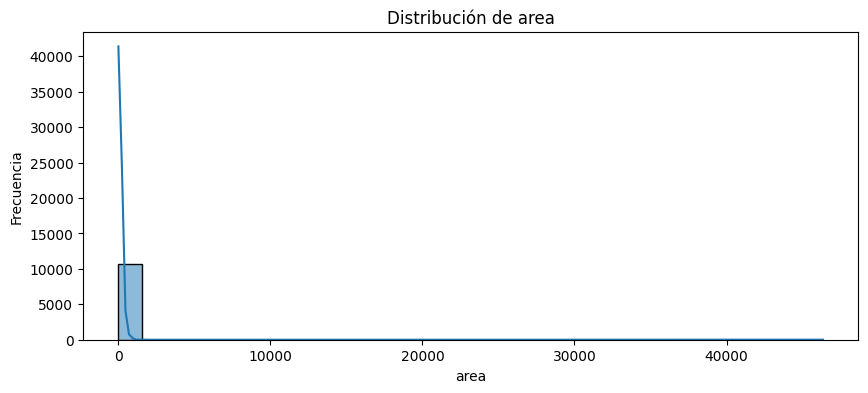

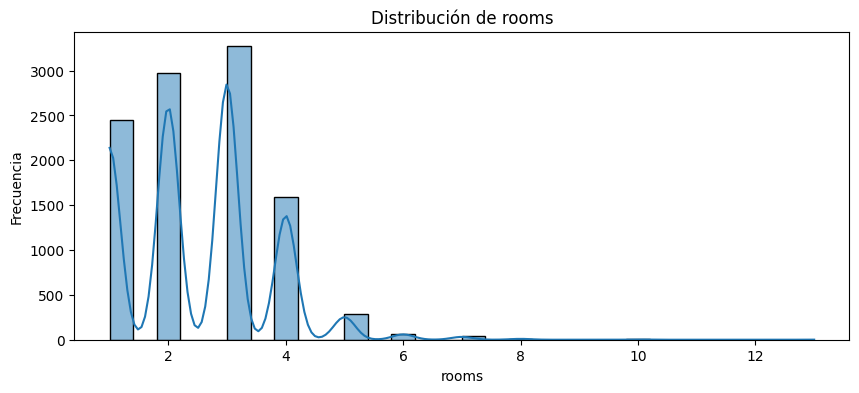

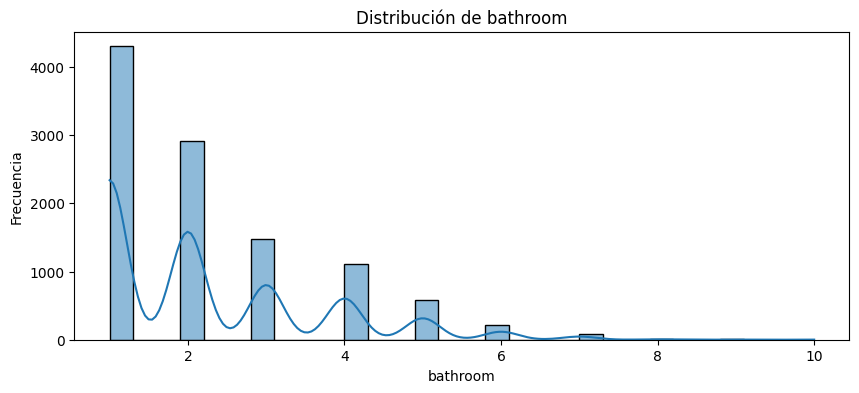

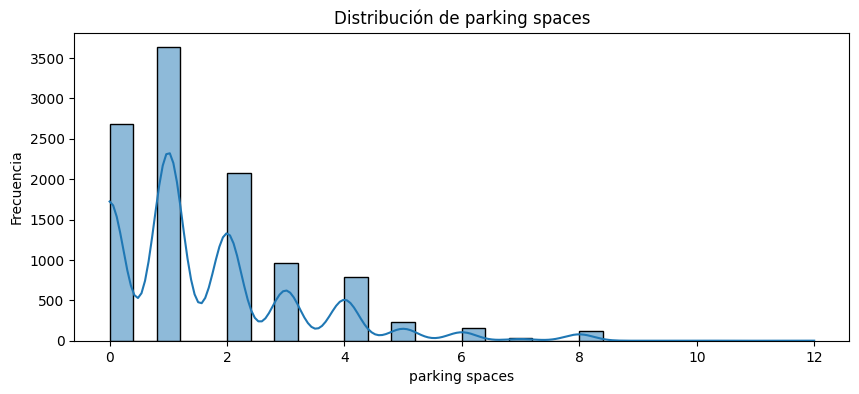

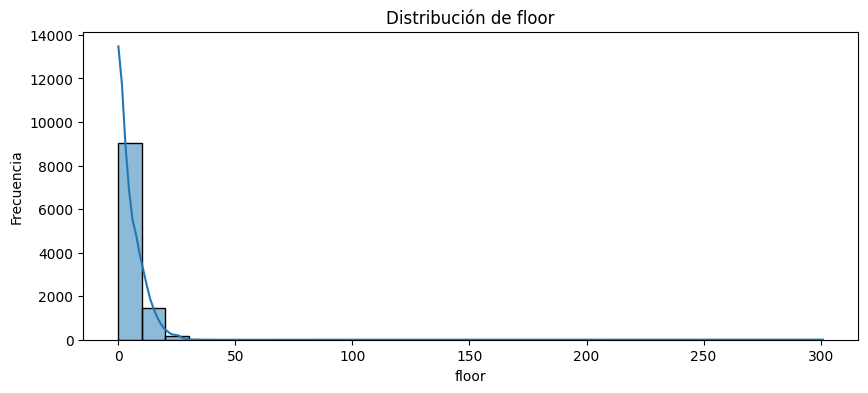

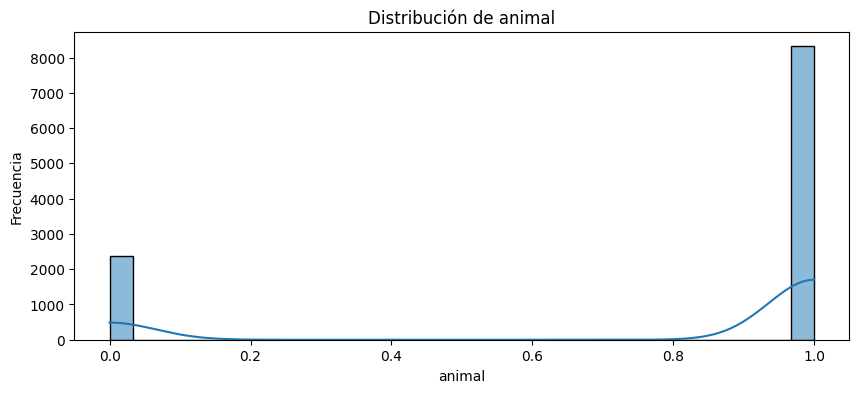

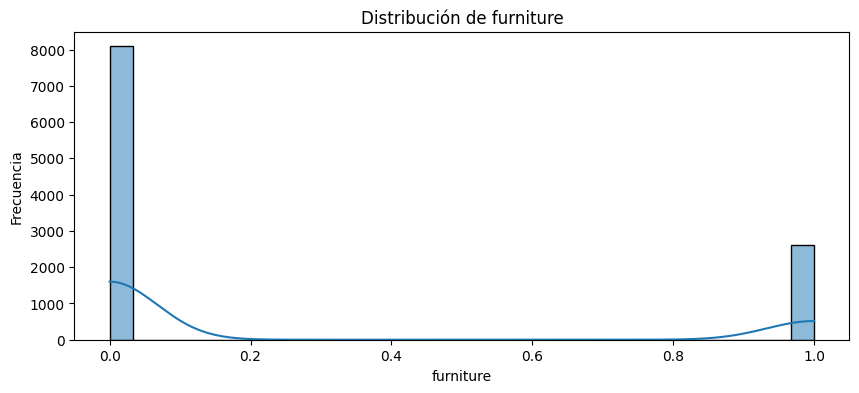

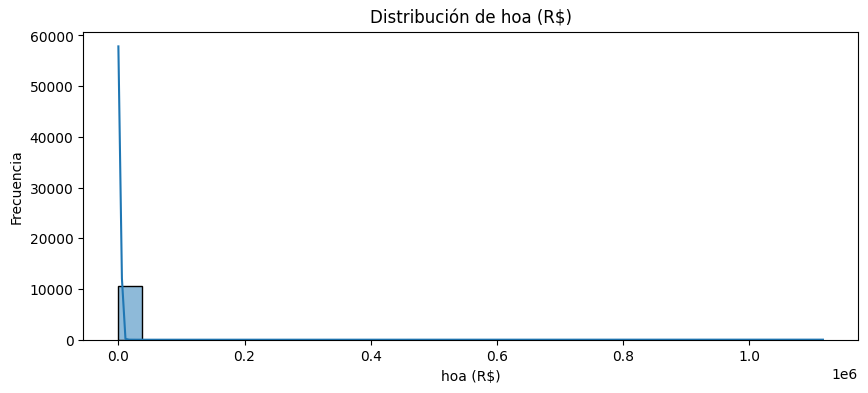

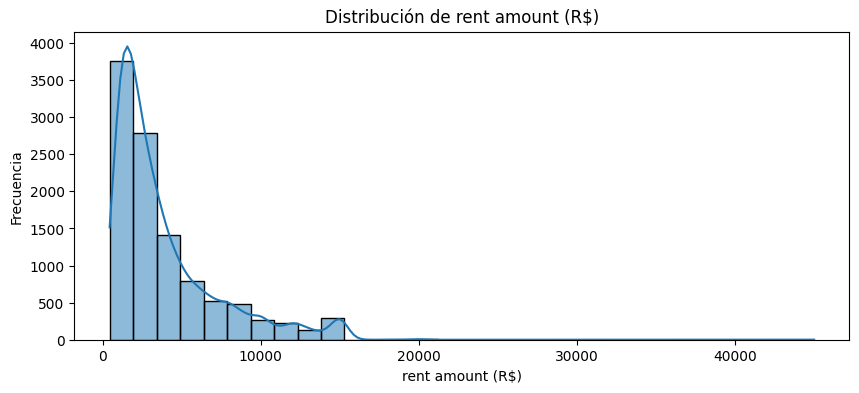

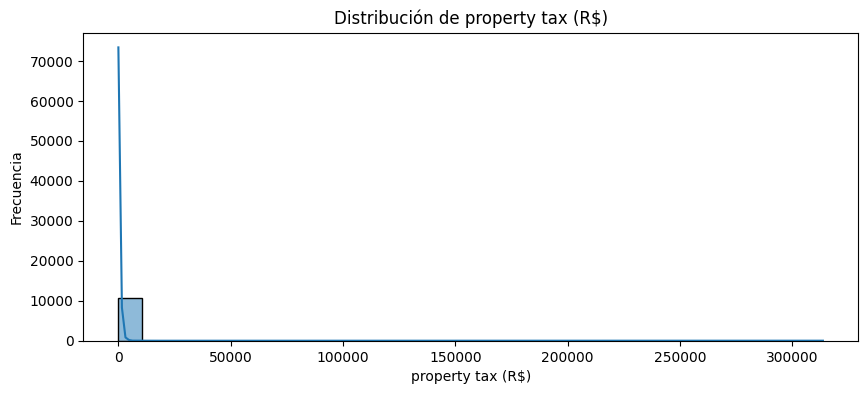

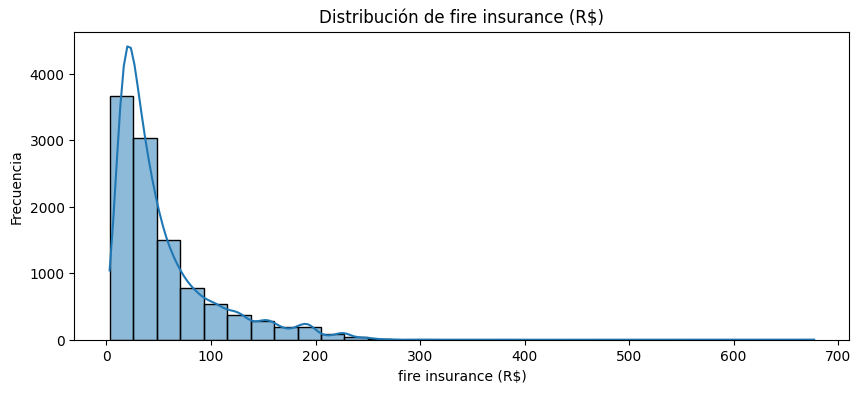

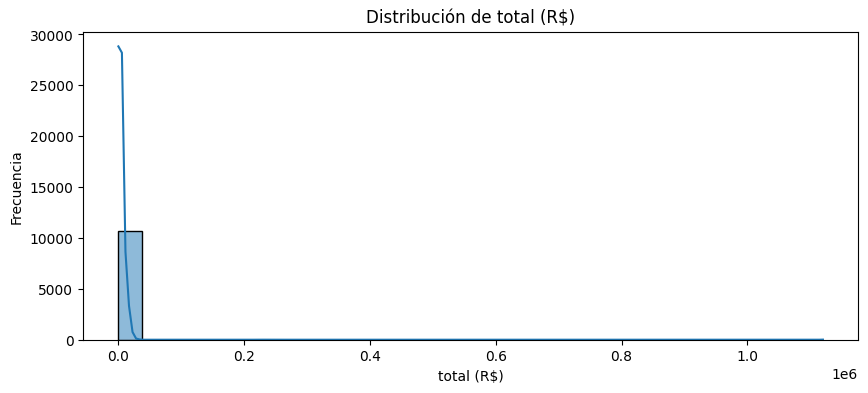

In [493]:
for columna in columnas_numericas:
    plt.figure(figsize=(10, 4))
    sns.histplot(dataframe[columna], kde=True, bins=30)
    plt.title(f'Distribución de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')
    plt.show()

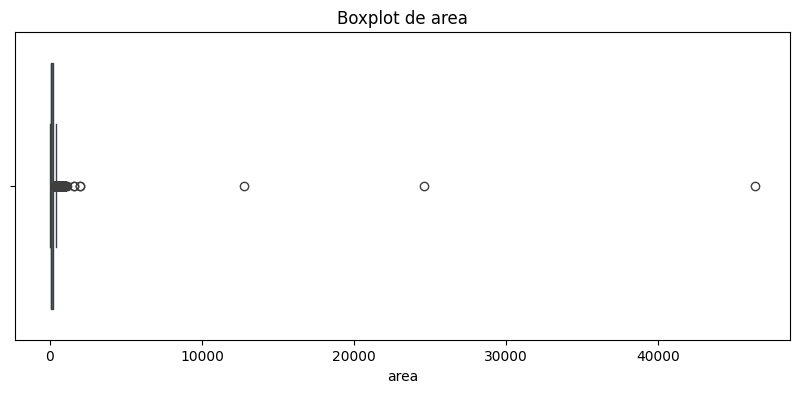

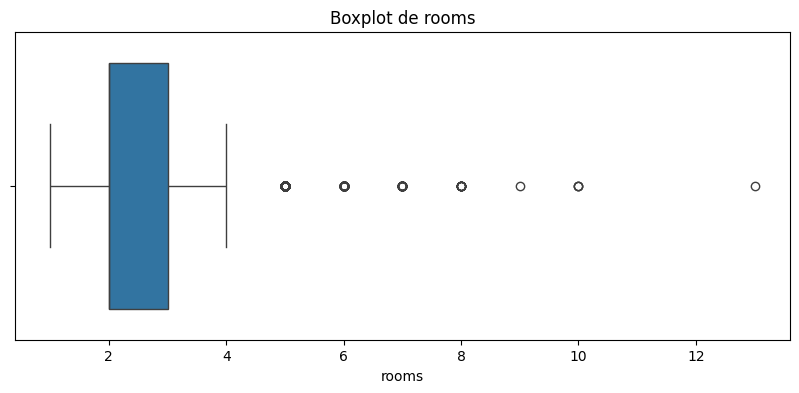

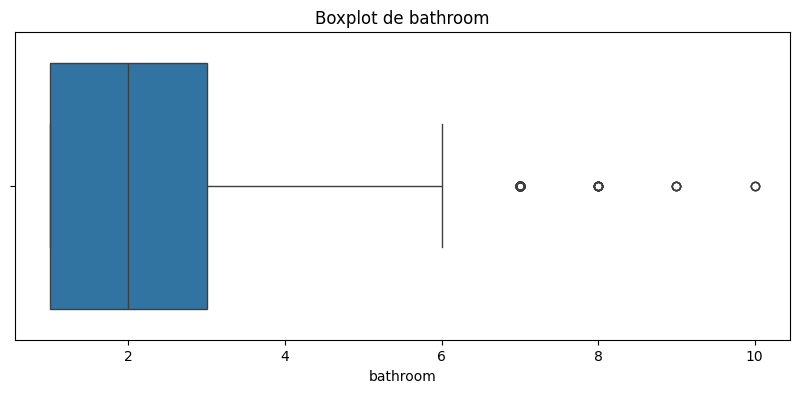

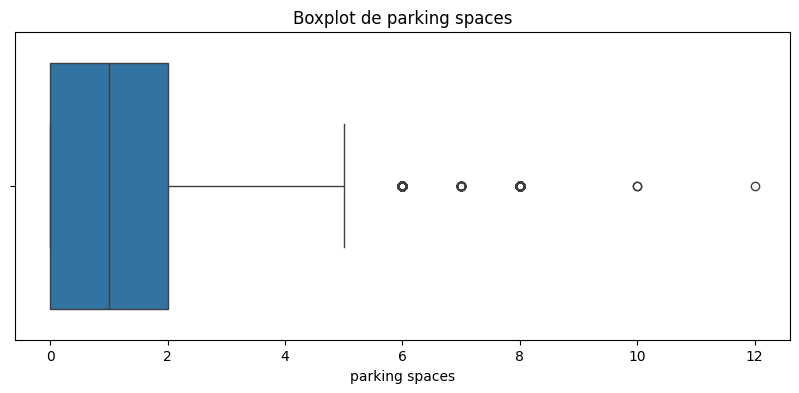

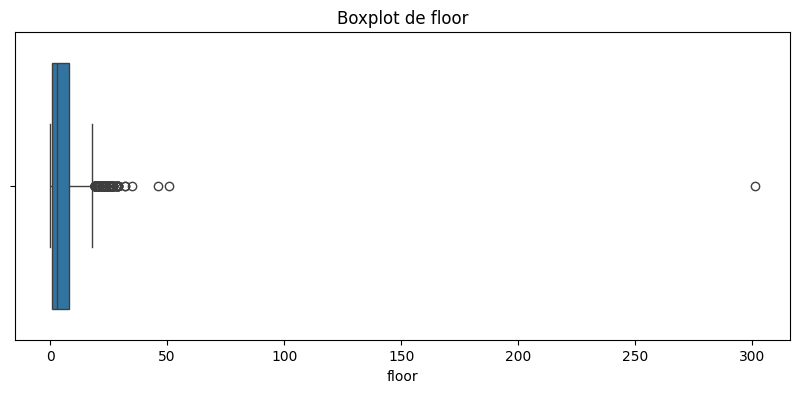

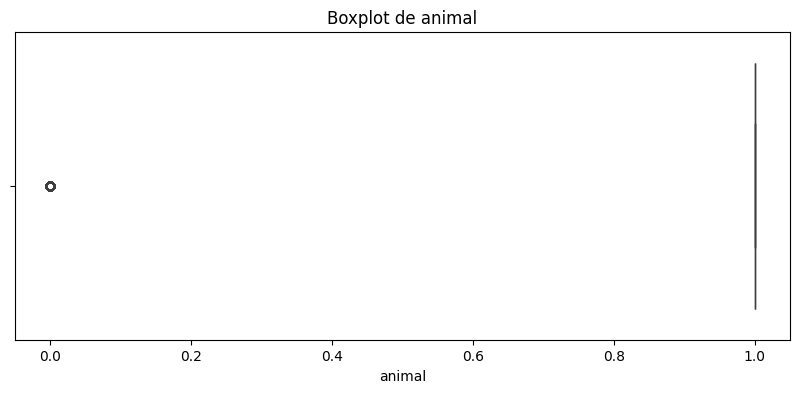

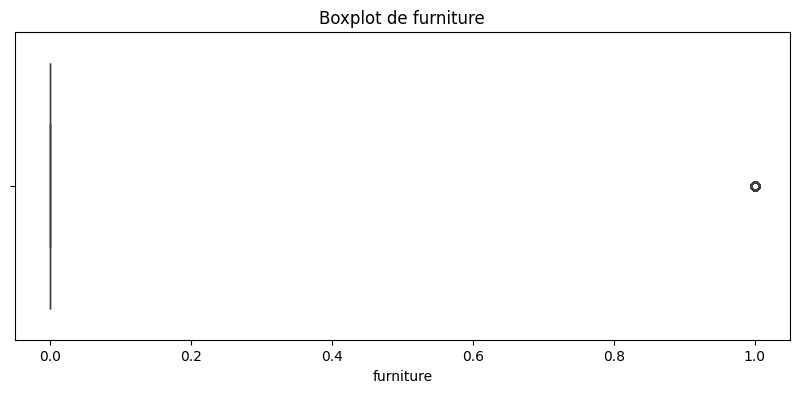

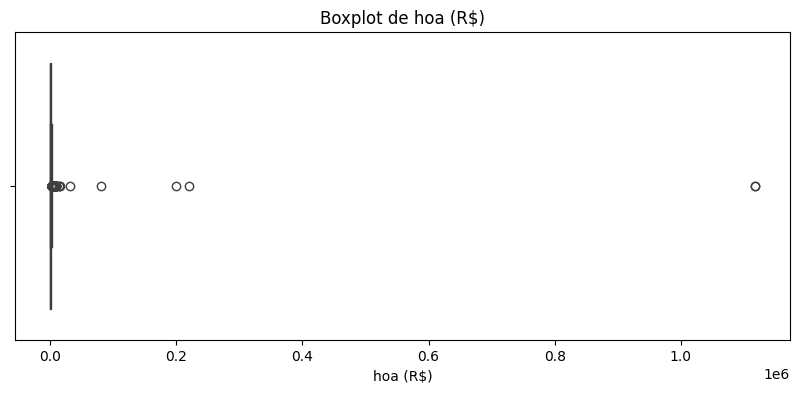

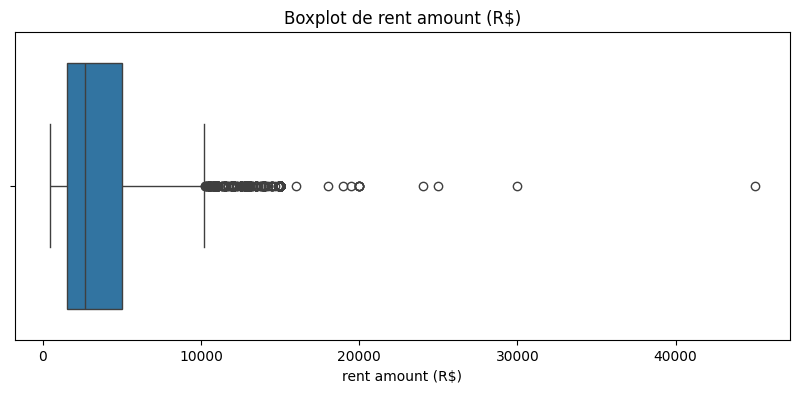

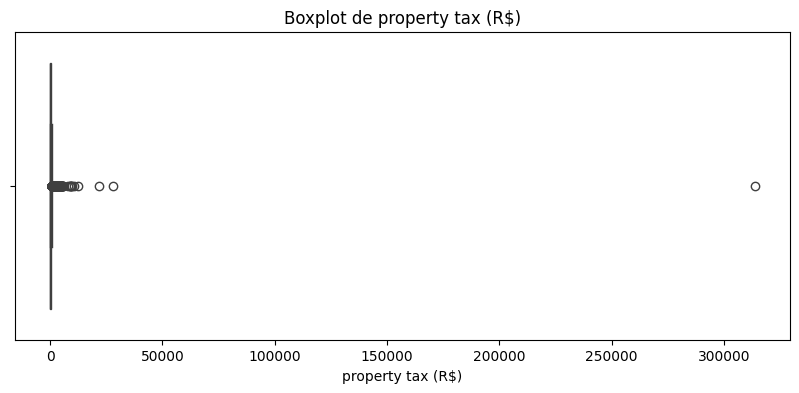

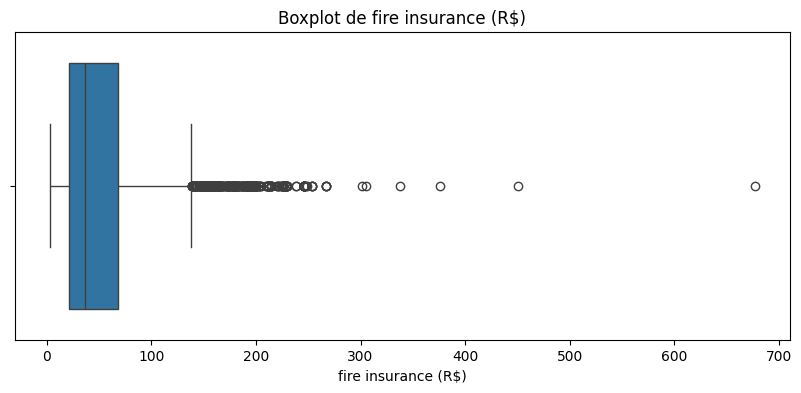

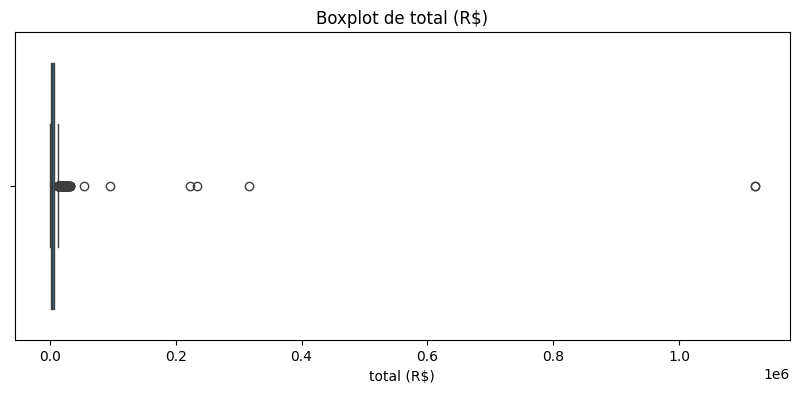

In [494]:
for columna in columnas_numericas:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=dataframe[columna])
    plt.title(f'Boxplot de {columna}')
    plt.xlabel(columna)
    plt.show()

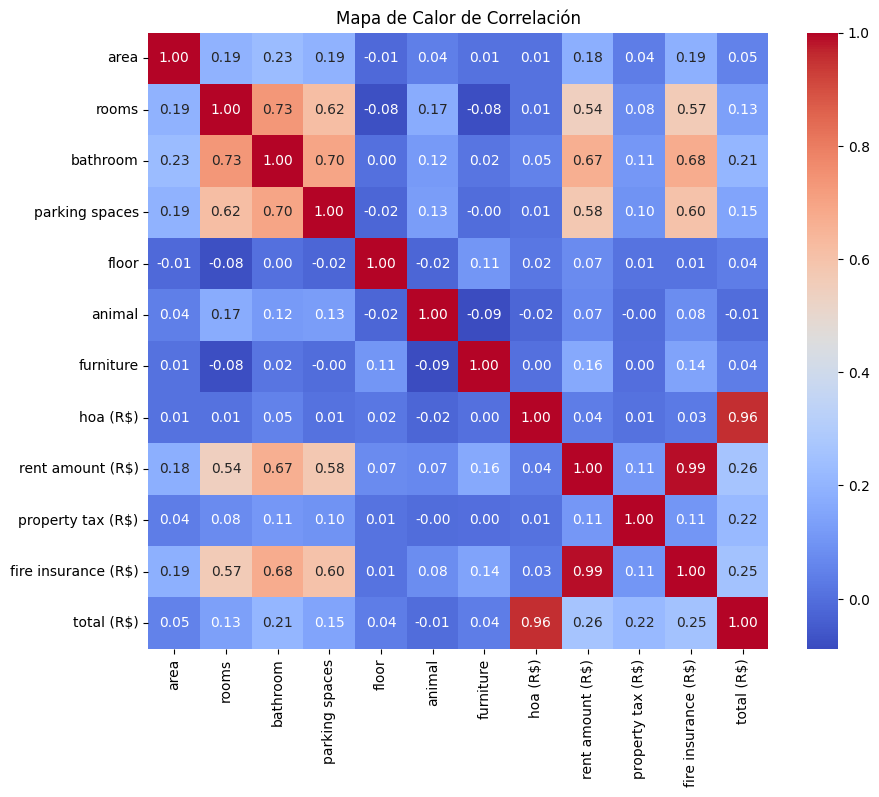

In [495]:
correlacion = dataframe.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Mapa de Calor de Correlación')
plt.show()

In [496]:
dataframe.isnull().sum()

city                   0
area                   0
rooms                  0
bathroom               0
parking spaces         0
floor                  0
animal                 0
furniture              0
hoa (R$)               0
rent amount (R$)       0
property tax (R$)      0
fire insurance (R$)    0
total (R$)             0
dtype: int64

In [497]:
dataframe.sort_values(by='area', ascending=False).head(10)

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
2397,Belo Horizonte,46335,4,8,5,11,1,1,960,8500,646,114,10220
5915,São Paulo,24606,5,4,4,12,1,0,2254,8100,7859,103,18320
9241,Campinas,12732,3,2,0,3,1,0,700,1600,96,21,2417
8790,Belo Horizonte,2000,3,3,2,2,1,1,3000,5000,200,67,8267
5129,Belo Horizonte,2000,4,2,3,0,1,0,0,4956,200,82,5238
654,São Paulo,1600,6,6,6,0,1,1,0,7600,1834,115,9549
4813,São Paulo,1600,4,5,12,0,1,0,1,6900,5000,104,12010
3559,São Paulo,1100,4,6,10,0,1,0,3000,14000,2000,211,19210
2423,Belo Horizonte,1020,5,4,6,0,1,1,0,6520,654,107,7281
1250,São Paulo,1000,4,7,4,10,1,1,6000,15000,4900,191,26090


In [498]:
dataframe.sort_values(by='rooms', ascending=False).head(10)

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
7835,Rio de Janeiro,439,13,4,3,0,1,0,0,15000,667,229,15900
5178,São Paulo,400,10,9,8,0,1,0,0,8330,550,126,9006
1639,São Paulo,400,10,5,8,0,1,0,0,10900,1417,164,12480
752,Belo Horizonte,341,10,6,7,0,1,0,0,5500,459,91,6050
9565,São Paulo,400,9,4,4,0,1,0,100,12000,500,181,12780
3792,Belo Horizonte,800,8,7,4,0,1,0,0,14000,834,230,15060
6947,São Paulo,486,8,4,6,0,1,0,0,25000,2200,376,27580
169,São Paulo,320,8,4,0,0,1,0,450,10500,350,158,11460
456,São Paulo,450,8,5,5,0,1,0,0,8000,1000,121,9121
10587,Belo Horizonte,500,8,5,8,0,1,0,0,5000,150,82,5232


In [499]:
dataframe.sort_values(by='hoa (R$)', ascending=False).head(10)

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
255,Belo Horizonte,155,1,4,0,4,0,0,1117000,2790,64,38,1120000
6979,Belo Horizonte,155,1,4,0,4,0,0,1117000,2790,64,38,1120000
6230,São Paulo,340,5,4,2,7,1,0,220000,12000,1000,153,233200
2859,São Paulo,285,4,5,4,6,1,1,200000,20000,1834,254,222100
2928,Rio de Janeiro,35,1,1,0,1,1,1,81150,4500,9900,58,95610
1444,Porto Alegre,42,1,1,0,10,1,0,32000,700,40,11,32750
1213,São Paulo,850,6,7,4,0,0,0,15000,13000,2465,196,30660
415,São Paulo,488,4,3,3,0,1,0,14130,6400,1214,82,21820
5293,São Paulo,850,5,7,8,1,0,0,14000,4000,0,51,18050
8858,São Paulo,800,4,7,8,0,0,0,10000,8500,209,128,18840


In [500]:
dataframe.sort_values(by='rent amount (R$)', ascending=False).head(5)

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
2182,São Paulo,700,4,7,8,0,1,0,0,45000,8750,677,54430
7748,São Paulo,350,3,3,3,0,1,0,0,30000,560,451,31010
6947,São Paulo,486,8,4,6,0,1,0,0,25000,2200,376,27580
2619,São Paulo,80,2,1,1,1,1,0,875,24000,0,305,25180
1743,São Paulo,410,4,5,5,1,1,0,0,20000,0,254,20250


In [501]:
dataframe.sort_values(by='property tax (R$)', ascending=False).head(10)

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
6645,São Paulo,42,1,2,1,6,0,0,690,2500,313700,32,316900
6243,Rio de Janeiro,95,2,2,1,11,1,0,1024,3000,28120,39,32180
1699,São Paulo,700,4,4,4,0,1,0,0,10000,21880,151,32040
10172,Belo Horizonte,260,4,4,6,10,1,1,3200,11900,12500,159,27760
5331,São Paulo,300,4,5,5,6,0,0,3500,1990,10830,26,16350
2928,Rio de Janeiro,35,1,1,0,1,1,1,81150,4500,9900,58,95610
7674,São Paulo,890,5,6,8,0,0,0,0,11000,9500,166,20670
19,São Paulo,600,4,5,6,0,1,0,0,12000,9500,181,21680
8187,São Paulo,700,4,10,0,0,1,0,0,15000,8750,226,23980
2182,São Paulo,700,4,7,8,0,1,0,0,45000,8750,677,54430


In [502]:
dataframe.sort_values(by='total (R$)', ascending=False).head(10)

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
6979,Belo Horizonte,155,1,4,0,4,0,0,1117000,2790,64,38,1120000
255,Belo Horizonte,155,1,4,0,4,0,0,1117000,2790,64,38,1120000
6645,São Paulo,42,1,2,1,6,0,0,690,2500,313700,32,316900
6230,São Paulo,340,5,4,2,7,1,0,220000,12000,1000,153,233200
2859,São Paulo,285,4,5,4,6,1,1,200000,20000,1834,254,222100
2928,Rio de Janeiro,35,1,1,0,1,1,1,81150,4500,9900,58,95610
2182,São Paulo,700,4,7,8,0,1,0,0,45000,8750,677,54430
1444,Porto Alegre,42,1,1,0,10,1,0,32000,700,40,11,32750
6243,Rio de Janeiro,95,2,2,1,11,1,0,1024,3000,28120,39,32180
1699,São Paulo,700,4,4,4,0,1,0,0,10000,21880,151,32040


In [503]:
copyDataframe = dataframe.copy().drop([2397, 5915, 9241, 6979, 255, 6645, 6230, 2859, 2928, 1444])
copyDataframe['total teorico'] = copyDataframe['hoa (R$)'] + copyDataframe['rent amount (R$)'] + copyDataframe['property tax (R$)'] + copyDataframe['fire insurance (R$)']

mismatchedRows = copyDataframe[abs(copyDataframe['total teorico'] - copyDataframe['total (R$)']) > 100]

mismatchedRows['difference'] = mismatchedRows['total teorico'] - mismatchedRows['total (R$)']

C:\Users\ealva\AppData\Local\Temp\ipykernel_16456\3320143086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatchedRows['difference'] = mismatchedRows['total teorico'] - mismatchedRows['total (R$)']


In [504]:
mismatchedRows

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$),total teorico,difference
3652,Belo Horizonte,120,3,3,1,2,1,0,0,2200,145,30,2675,2375,-300
4994,São Paulo,94,3,3,2,1,1,0,750,2433,0,31,3593,3214,-379
5347,São Paulo,49,1,1,1,1,1,1,700,2985,0,38,3839,3723,-116
7755,São Paulo,65,2,1,1,3,1,0,590,2748,0,25,3479,3363,-116
8013,São Paulo,45,1,1,0,4,1,0,0,1000,0,13,1367,1013,-354


### b) Preprocesamiento y limpieza de datos

Como se puede apreciar, hay muchos valores atípicos el más impactante es en la variable 'area', donde el valor atípico indica un área de 46335mts cuadrados. Lo curioso de esto es que solamente cuenta con 4 cuartos y su precio final es 8000R$ menos que otra vivienda con menor área y más cuartos. Por lo que seguramente es un dato mal ingresado, al igual que esas otras tres áreas que se salen del rango "normal" que tiene el dataframe. Por lo que se optará por eliminar estas tres filas (IDs: 2397, 5915, 9241) que seguramente se trata de datos erróneos.
Aunque dentro de la variable de 'rooms' también se pueden apreciar datos atípicos, se decidió no eliminar ninguna de estas. Ya que, aunque puede parecer fuera de lo normal, puede que existan viviendas con estas características, ya que su área y su precio tampoco sale de lo normal.
Luego, para la variable del precio final 'total (R$)' también se pueden apreciar datos atípicos muy por encima de los demás estos datos podrían llegar a afectar el entrenamiento del modelo al contemplar precios tan elevados para viviendas las cuales no indican tener las mejores características, ya que en su mayoría cuentan con solamente 1 cuarto, sin lugar para automóviles y regularmente con más baños que cuartos, algo un poco inusual (ya que luego en base a las correlaciones se verá que estos datos influyen entre sí). Por esas razones se decidió eliminar esas filas (IDs: 6979, 255, 6645, 6230, 2859). También para la variable 'hoa (R$)' se identificaron dos valores atípicos muy por encima de los demás, por lo que se decidió eliminarlos también (IDs: 2928, 1444)
Aunque quizás un poco "rebuscado", se vio que la variable 'total (R$)' tiene alta relación con las variables de 'hoa', 'rent amount', 'property tax' y 'fire insurance', básicamente que la suma de las mencionadas daría como resultado el valor de 'total'. Claro, puede o no estar dentro de ciertas incertidumbres. Para esto se creó una copia del dataframe con el fin de analizar aquellas filas las cuales la suma de las variables mencionadas anteriormente NO dieran como resultado un valor dentro de cierto rango comparado con el total dado en el CSV (un rango arbitrario) y nos arrojó que la mayor diferencia entre este total teórico y el total real fue de R$ 379, por lo que se decidió no tomar ninguna acción relacionada a este último análisis.

Finalemente, el mapa de correlación indica los siguientes puntos:
- La variable hoa, rent amount, property tax, fire insurance y el total están fuertemente ligadas, lo cuál tiene lógica ya que a apartir de estas es que la vivienda toma el precio final. Claro, algunas más que otras, pero siempre presentan cierta correlación.
- La cantidad de cuartos, baños y espacios para vehículos muestran una relación fuerte. Lo cuál también tiene sentido.
- La variable de floor no parece mostrar ninguna relación significativa con ninguna otra variable. Por lo que seguramente no afectará la eliminación de dicha variable ya que no llega a influir en ningun aspecto, ni en la variable objetivo la cuál es total.

También mencionar que no existen datos faltantes, por lo que no habrá necesidad de tomar acciones relacionadas a esto. Los outliers identificados se eliminarán. Se realizará la codificación de la única variable categórica que quedó, la cuál es city. Y claro, siempre se normalizarán los datos.

**Nota:** Claramente no somos expertos en el tema. Todas las decisiones se tomaron basándonos en la lectura de un artículo simple y resumido que hablaba del precio de alquier de apartamentos en Brasil. Donde se detallaba lo que influía en el precio total del alquiler y cómo éste cambia si se está dentro y fuera de zona urbana (Donde la principal es Sau Paulo).
Referencia: https://aparthotel.com/es/analyze/brazil/average-rent-in-brazil/

In [505]:
dataframe = dataframe.drop([2397, 5915, 9241, 6979, 255, 6645, 6230, 2859, 2928, 1444])

In [506]:
dataframe = dataframe.drop(['floor'], axis=1)

#### Evaluación de cambios luego de limpieza

In [507]:
dataframe.head(5)

,city,area,rooms,bathroom,parking spaces,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,1,1,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,1,0,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,1,0,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,1,0,270,1112,22,17,1421
4,São Paulo,25,1,1,0,0,0,0,800,25,11,836


In [508]:
dataframe.describe()

,area,rooms,bathroom,parking spaces,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000
mean,141.425857,2.505991,2.235630,1.609156,0.777851,0.243681,915.641827,3893.951975,335.667478,53.273825,5198.724022
std,134.360356,1.170676,1.405978,1.589193,0.415711,0.429322,1127.684431,3404.862987,678.854415,47.731423,4489.249735
min,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,450.000000,0.000000,3.000000,499.000000
25%,56.000000,2.000000,1.000000,0.000000,1.000000,0.000000,170.000000,1530.000000,38.000000,21.000000,2060.250000
50%,90.000000,2.000000,2.000000,1.000000,1.000000,0.000000,557.500000,2655.000000,125.000000,36.000000,3577.500000
75%,182.000000,3.000000,3.000000,2.000000,1.000000,0.000000,1232.250000,5000.000000,375.000000,68.000000,6757.000000
max,2000.000000,13.000000,10.000000,12.000000,1.000000,1.000000,15000.000000,45000.000000,28120.000000,677.000000,54430.000000


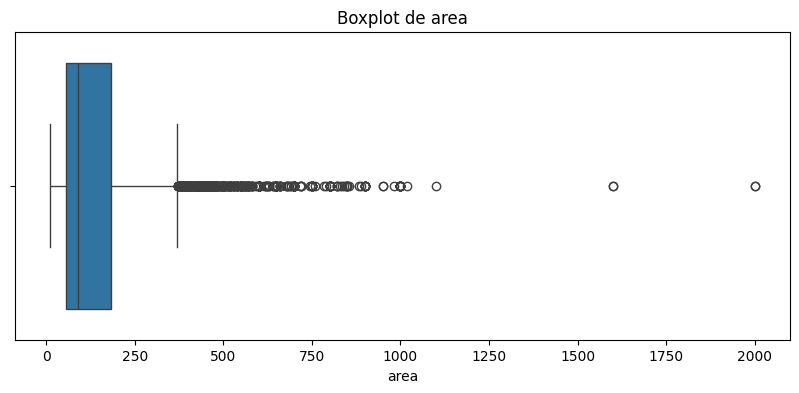

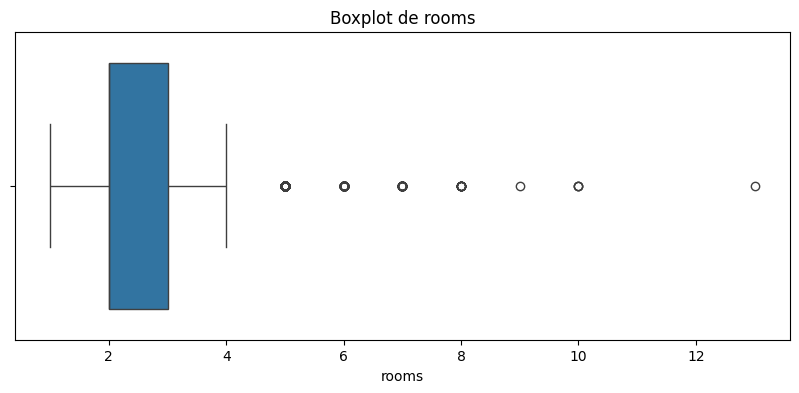

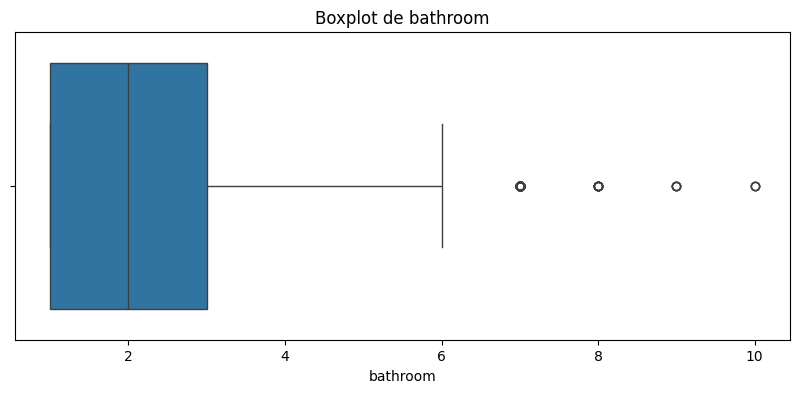

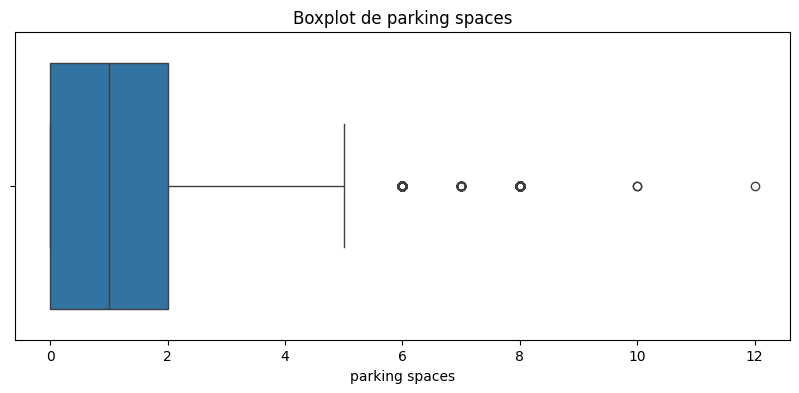

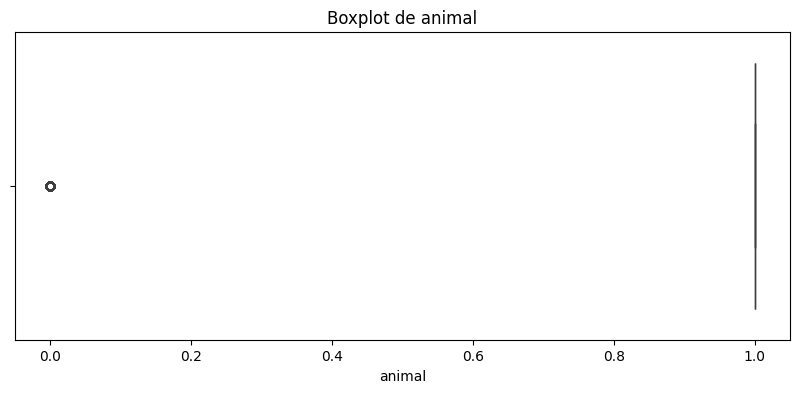

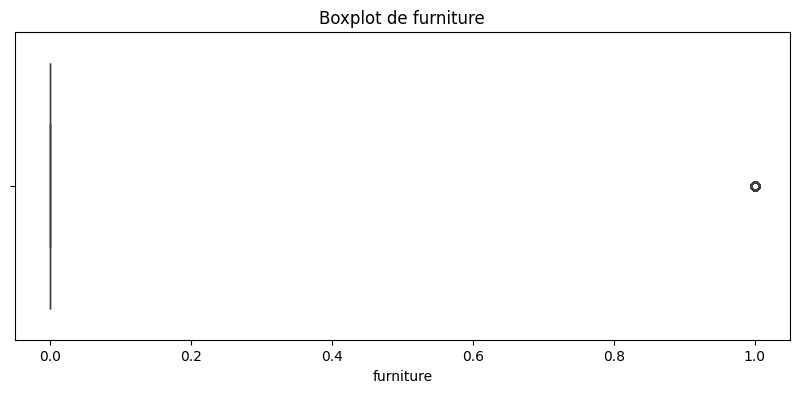

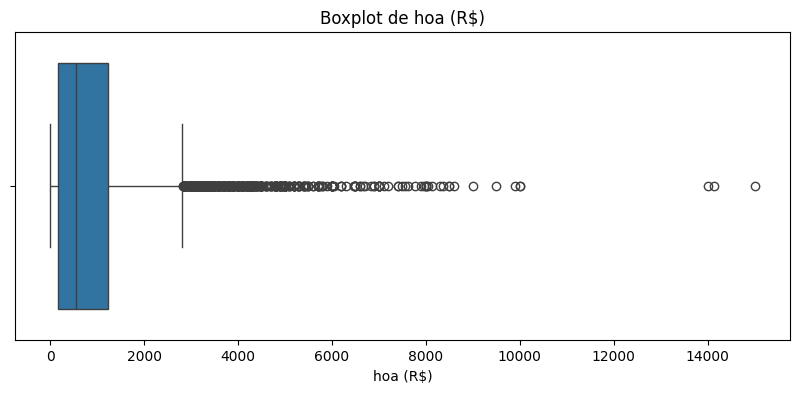

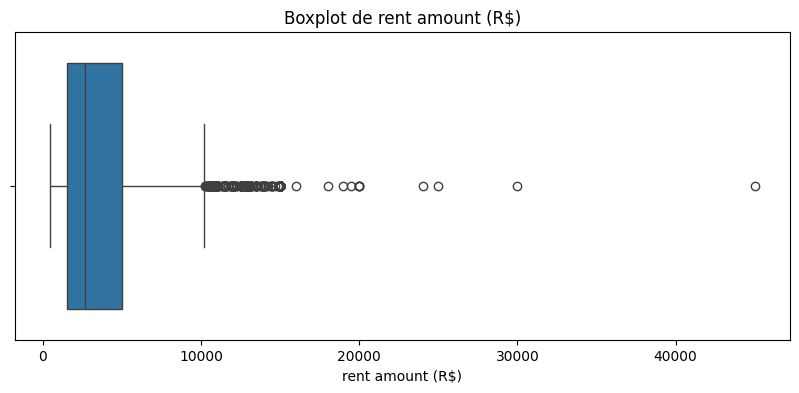

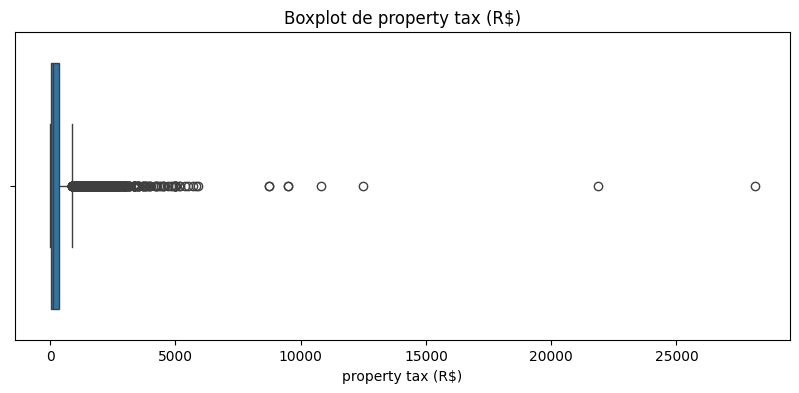

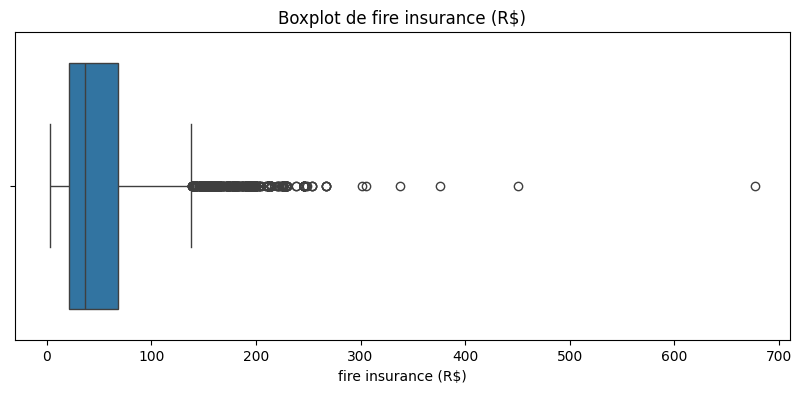

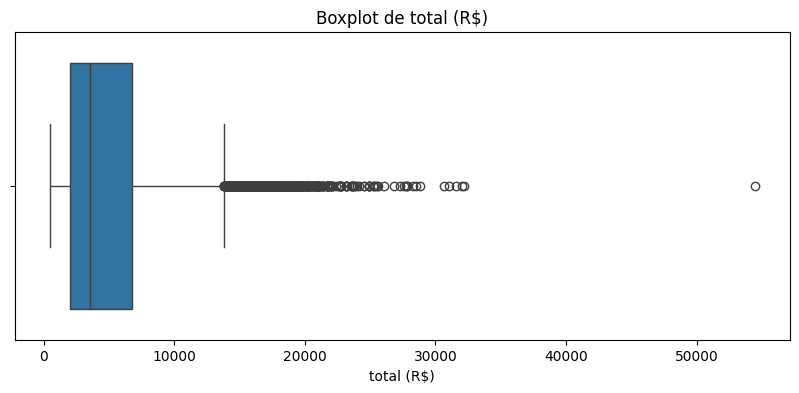

In [509]:
columnas_numericas = dataframe.select_dtypes(include=['number']).columns
for columna in columnas_numericas:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=dataframe[columna])
    plt.title(f'Boxplot de {columna}')
    plt.xlabel(columna)
    plt.show()

Se puede observar unos datos un poco más centrados. Sí, siempre existen atípicos, pero no son tan notables como se tenían anteriormente.

#### Normalización y codificación

In [514]:
scalerX = MinMaxScaler()
scaledDataframe1 = pd.DataFrame(scalerX.fit_transform(dataframe.iloc[:,1:-1]), columns=dataframe.columns[1:-1])
scaledDataframe1
scalerY = MinMaxScaler()
scaledDataframe2 = pd.DataFrame(scalerY.fit_transform(dataframe.iloc[:,-1].values.reshape(-1,1)), columns=[dataframe.columns[-1]])
scaledDataframe2
scaledDataframe = pd.concat([dataframe.iloc[:,0], scaledDataframe1, scaledDataframe2], axis=1)

In [515]:
scaledDataframe.describe()

,area,rooms,bathroom,parking spaces,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000
mean,0.065574,0.125499,0.137292,0.134096,0.777851,0.243681,0.061043,0.077305,0.011937,0.074590,0.087143
std,0.067552,0.097556,0.156220,0.132433,0.415711,0.429322,0.075179,0.076428,0.024141,0.070818,0.083241
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.022624,0.083333,0.000000,0.000000,1.000000,0.000000,0.011333,0.024242,0.001351,0.026706,0.028949
50%,0.039718,0.083333,0.111111,0.083333,1.000000,0.000000,0.037167,0.049495,0.004445,0.048961,0.057082
75%,0.085973,0.166667,0.222222,0.166667,1.000000,0.000000,0.082150,0.102132,0.013336,0.096439,0.116037
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [452]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encodedCategorical = pd.DataFrame(encoder.fit_transform(dataframe[columnas_no_numericas]), columns=encoder.get_feature_names_out(columnas_no_numericas))
encodedCategorical

,city_Campinas,city_Porto Alegre,city_Rio de Janeiro,city_São Paulo
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
10677,0.0,1.0,0.0,0.0
10678,0.0,0.0,0.0,1.0
10679,0.0,0.0,1.0,0.0
10680,0.0,0.0,1.0,0.0


In [453]:
dataframe = pd.concat([encodedCategorical, scaledDataframe], axis=1)

In [454]:
dataframe

,city_Campinas,city_Porto Alegre,city_Rio de Janeiro,city_São Paulo,area,rooms,bathroom,parking spaces,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,0.0,0.0,0.0,1.0,0.029663,0.083333,0.000000,0.083333,1.0,1.0,0.137667,0.063973,0.007504,0.057864,0.094918
1,0.0,0.0,0.0,1.0,0.155354,0.250000,0.333333,0.000000,1.0,0.0,0.080000,0.101235,0.062233,0.089021,0.138584
2,0.0,1.0,0.0,0.0,0.034691,0.000000,0.000000,0.083333,1.0,0.0,0.066667,0.052750,0.000000,0.056380,0.061968
3,0.0,1.0,0.0,0.0,0.020111,0.083333,0.000000,0.000000,1.0,0.0,0.018000,0.014860,0.000782,0.020772,0.017096
4,0.0,0.0,0.0,1.0,0.007039,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.007856,0.000889,0.011869,0.006249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,0.0,1.0,0.0,0.0,0.026144,0.083333,0.000000,0.083333,0.0,1.0,0.026800,0.023075,0.000853,0.028190,0.026460
10678,0.0,0.0,0.0,1.0,0.137758,0.250000,0.333333,0.333333,1.0,0.0,0.206667,0.326599,0.034602,0.278932,0.347870
10679,0.0,0.0,1.0,0.0,0.029663,0.166667,0.222222,0.000000,0.0,1.0,0.065333,0.124579,0.011807,0.111276,0.127774
10680,0.0,0.0,1.0,0.0,0.054801,0.083333,0.111111,0.166667,1.0,1.0,0.105667,0.259259,0.009922,0.225519,0.250709


In [455]:
dataframe.to_csv('houses_to_rent_v2_clean.csv', index=False)

### c) Entrenamiento y selección de modelos

In [456]:
X = dataframe.drop('total (R$)', axis=1)
y = dataframe['total (R$)']
X_entreno, X_prueba, y_entreno, y_prueba = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [464]:
def tryModel(model, X_entreno, X_prueba, y_entreno, y_prueba):
    kf = KFold(n_splits=5, shuffle=True, random_state=101)
    
    model.fit(X_entreno, y_entreno)
    
    r2 = cross_val_score(model, X_entreno, y_entreno, cv=kf, scoring='r2').mean()
    rmse = np.sqrt(-cross_val_score(model, X_entreno, y_entreno, cv=kf, scoring='neg_mean_squared_error')).mean()
    mae = -cross_val_score(model, X_entreno, y_entreno, cv=kf, scoring='neg_mean_absolute_error').mean()
    
    y_pred = model.predict(X_prueba)
    r2Test = r2_score(y_prueba, y_pred)
    rmseTest = np.sqrt(mean_squared_error(y_prueba, y_pred))
    maeTest = mean_absolute_error(y_prueba, y_pred)
    
    print(f"Modelo: {model.__class__.__name__}")
    print(f"Entrenamiento:\n\tR2: {r2:.4f}\n\tRMSE: {rmse:.4f}\n\tMAE: {mae:.4f}")
    print(f"Prueba:\n\tR2: {r2Test:.4f}\n\tRMSE: {rmseTest:.4f}\n\tMAE: {maeTest:.4f}")
    print("\n")

    return model

In [571]:
linear = LinearRegression()
randomForest = RandomForestRegressor(n_estimators=100, random_state=42)
gradientBoosting = GradientBoostingRegressor(n_estimators=100, random_state=42)
knn = KNeighborsRegressor(n_neighbors=3)
lasso = Lasso(alpha=0.1)

modelos = [linear, randomForest, gradientBoosting, knn, lasso]
fitModels = []

for model in modelos:
    fitModels.append(tryModel(model, X_entreno, X_prueba, y_entreno, y_prueba))

Modelo: LinearRegression
Entrenamiento:
	R2: 1.0000
	RMSE: 0.0001
	MAE: 0.0000
Prueba:
	R2: 1.0000
	RMSE: 0.0002
	MAE: 0.0000


Modelo: RandomForestRegressor
Entrenamiento:
	R2: 0.9855
	RMSE: 0.0089
	MAE: 0.0017
Prueba:
	R2: 0.9887
	RMSE: 0.0089
	MAE: 0.0016


Modelo: GradientBoostingRegressor
Entrenamiento:
	R2: 0.9920
	RMSE: 0.0066
	MAE: 0.0022
Prueba:
	R2: 0.9958
	RMSE: 0.0055
	MAE: 0.0021


Modelo: KNeighborsRegressor
Entrenamiento:
	R2: 0.9372
	RMSE: 0.0207
	MAE: 0.0107
Prueba:
	R2: 0.9467
	RMSE: 0.0194
	MAE: 0.0100


Modelo: Lasso
Entrenamiento:
	R2: -0.0002
	RMSE: 0.0830
	MAE: 0.0623
Prueba:
	R2: -0.0002
	RMSE: 0.0840
	MAE: 0.0630




## Análisis de resultados

A simple vista, todos los modelos entregaron un rendimiento bastante bueno.
Se podría pensar que el modelo de Linear Regression es el mejor de todos, pero el tener un R2 igual a 1 podría decir que el modelo está sobreajustado por lo que no nos servirá de mucho. Desde ya lo descartamos por eso.
Gradient Boosting Regressor tuvo un R2 de 0.992, un indicador muy bueno y coherente, su RMSE indica que la diferencia entre los valores predichos y el real es casi nula. Un gran cantidato hasta el momento.
Random Forest entregó un R2 de 0.9855, bastante cercano al modelo anterior pero no lo  suficiente, aunque su RMSE también fue bastante bueno ya que fue de 0.0089. Aunque por el momento, Gradient Boosting sigue siendo el lider.
Por otra parte tenemos a KNN, con un R2 de 0.9372 y un RMSE de 0.0207, valores bastante buenos, pero aún no tan buenos como Gradient Boosting.
Finalmente, la regresión de Lasso entregó un R2: -0.0002 y un RMSE de 0.0830, valores bastante buenos pero que aun no son tan buenos como Gradient Boosting.

Dado lo anterior, se tomará como modelo de producción el modelo de Gradient Boosting Regressor.
Entre sus principales ventajas está la captura de datos no lineales, como los que tenemos actualmente, ya que la variable objetivo está compuesta por muchas otras variables de economía y zonas en Brasil, algo que de por sí es muy difícil de comprender y mucho más de aplicar. Además, de que gracias a que combina múltiples árboles de decisión, este modelo logra reducir significativamente el sesgo como la varianza, algo que quedó perfecto en nuestro caso al manejar aún datos atípicos (que ya se mencionó, estaban dentro de un valor con sentido). Aunque presentó grandes resultados, fue necesario una limpieza y normalización de datos bastante compleja, que seguramente fue lo que ayudó a este modelo a tener el mejor desempeño a comparación del resto.

# Guardar modelo, normalizadores y codificadores

In [559]:
with open('model.pkl', 'wb') as file:
    pickle.dump(fitModels[2], file)

with open('scalerX.pkl', 'wb') as file:
    pickle.dump(scalerX, file)

with open('scalerY.pkl', 'wb') as file:
    pickle.dump(scalerY, file)

with open('encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

# Pruebas de funcinalidad para predecir datos desde un valor ingresado

In [560]:
X_prueba.head(1)

,city_Campinas,city_Porto Alegre,city_Rio de Janeiro,city_São Paulo,area,rooms,bathroom,parking spaces,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
7098,0.0,0.0,0.0,0.0,0.061337,0.166667,0.111111,0.25,0.0,0.0,0.053733,0.037037,0.005725,0.037092


In [561]:
X_prueba.head(1)
X_prueba_desnormalizado = pd.DataFrame(scalerX.inverse_transform(X_prueba.head(1).iloc[:,4:]), columns=X_prueba.columns[4:])
X_prueba_desnormalizado

,area,rooms,bathroom,parking spaces,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
0,133.0,3.0,2.0,3.0,0.0,0.0,806.0,2100.0,161.0,28.0


In [562]:
y_prueba.head(1)

7098    0.048136
Name: total (R$), dtype: float64

In [563]:
y_prueba_desnormalizado = scalerY.inverse_transform(y_prueba.head(1).values.reshape(-1,1))
y_prueba_desnormalizado

array([[3095.]])

In [564]:
test = {
    'city_Campinas': 0.0,
    'city_Porto Alegre': 0.0,
    'city_Rio de Janeiro': 0.0,
    'city_São Paulo': 0.0,
    'area': 0.008547,
    'rooms': 0.0,
    'bathroom': 0.0,
    'parking spaces': 0.083333,
    'animal': 0.0,
    'furniture': 1.0,
    'hoa (R$)': 0.036667,
    'rent amount (R$)': 0.017957,
    'property tax (R$)': 0.0,
    'fire insurance (R$)': 0.020772
}

test = pd.DataFrame(test, index=[0])

predccion = fitModels[2].predict(test)

print(f"Predicción: {predccion[0]}")

Predicción: 0.02472840484002297


In [569]:
def predict(datos):
    test = pd.DataFrame([datos])

    scaler_X = scalerX

    datosNormalizados = pd.DataFrame(scaler_X.transform(test.iloc[:,1:]), columns=test.columns[1:])
    #datosNormalizados
    datosCodificados = pd.DataFrame(encoder.transform(test.iloc[:,0:1]), columns=encoder.get_feature_names_out(['city']))
    #datosCodificados

    test = pd.concat([datosCodificados, datosNormalizados], axis=1)
    test

    predccionNormalizada = fitModels[2].predict(test)
    #predccionNormalizada

    predccion = scalerY.inverse_transform(predccionNormalizada.reshape(-1,1))
    print(f"Predicción: {predccion[0]}")

In [577]:
test = {
    'city': 'Rio de Janeiro',
    'area': 133,
    'rooms': 3.0,
    'bathroom': 2.0,
    'parking spaces': .0,
    'animal': 0.0,
    'furniture': 0.0,
    'hoa (R$)': 806.0,
    'rent amount (R$)': 2100.0,
    'property tax (R$)': 161.0,
    'fire insurance (R$)': 28.0
}


predict(test)

Predicción: [3129.99320009]
